In [36]:
#Setup
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt


# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [2]:
def readData(filename):
    convertfunc = lambda x: (pd.to_datetime(x,utc=True)).tz_convert('Asia/Kolkata')
    return pd.read_csv(filename,
                    names=["DateTime","open","high","low","close","volume"],
                    dtype=None,
                    delimiter = ',',
                    converters = {0:convertfunc},
                  #  index_col = 0
                   )

# Making sure that 2 timeseries are synced to the smaller time series 
def sanitizeTimeSeries(ts1,ts2):
    # If TS1 is not bigger, then make TS1 the bigger one and TS2 the smaller one.
    flipped = 0
    if len(ts2) > len(ts1):
        flipped = 1
        ts1,ts2 = ts2,ts1
    for dt in ts1["DateTime"].values:
        if dt in ts2['DateTime'].values:
            continue
        else:
            #print(dt)
            ts1.drop(ts1[ts1["DateTime"]==dt].index,inplace = True)
    if flipped:
        return ts2, ts1.reset_index(drop = True)
    else:
        return ts1.reset_index(drop = True), ts2
    

#Creates Lagged series to generate 60-1 x y split    
def timeseriesLagged(data, lag=60):
    df = data
    columns = [df.shift(i) for i in range(1, lag+2)] 
    df = pd.concat(columns,axis=1)
    df.fillna(0, inplace=True)
    df.columns = [str(lag+2-x) for x in range(1,lag+2)]
    df = df[df.columns[::-1]] #Flip because we want newer data on the right
    df= df.iloc[lag+1:] # drop the first 'lag' columns because zeroes.
    df.reset_index(drop=True,inplace=True)
    return df


# Binarizes the last column into 1 or 0.
# dif is the cost to buy. Rate is the per transasction cost. max is
def binarizeTime(series,lag,dif=0,rate=0.01,maxPer=[20]):
    #-1 is autocalculate the dif 
    if dif != 0:
        raise Exception("dif not yet baked in! ")
    series[str(lag+1)] = np.where(series[str(lag)] + dif < series[str(lag+1)], 1, 0)
    return series

In [143]:
# Setup Parameters
dataInit = readData("data/TRIL.csv")
data = dataInit['close'].diff().dropna() #difference the data and drop the useless rows
#data = (data-data.min())/(data.max()-data.min()) # Min max normalize
#data = data/np.linalg.norm(data) #vector norm
#data = np.log(data)
lag = 4 # 24*5 minutes
dif = 0 # difference between prices to trigger purchase for binarize
series = timeseriesLagged(data,lag)


# Turn the 61st column into or zero
#series = binarizeTime(series,lag,dif)
seriesVals = series.values

#Split into train and test
trainBegin = int(0.8*len(seriesVals))
train = seriesVals[0:trainBegin]
test = seriesVals[trainBegin:]

# Split into x and y
xTrain,yTrain = train[:,0:-1],train[:,-1] # X is the first 60 elements. Y is the 61st element
xTest,yTest = test[:,0:-1],test[:,-1]

#Reshape for keras
xTrain = xTrain.reshape((xTrain.shape[0], xTrain.shape[1], 1))
xTest = xTest.reshape(xTest.shape[0], xTest.shape[1],1)

In [123]:
xTrain.shape


(6220, 4, 1)

In [135]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
import time

model = Sequential()
layers = [1, 50, 100,150, 1]
model.add(LSTM(
        layers[1],
        input_shape=(None, 1),
        return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
        layers[2],
        return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
        layers[3],
        return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
        layers[4]))
model.add(Activation("linear"))
start = time.time()
model.compile(loss="mse", optimizer="rmsprop")
print ("Compilation Time : " + str(time.time() - start))
model.summary()

Compilation Time : 0.00895833969116211
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, None, 50)          10400     
_________________________________________________________________
dropout_30 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
lstm_34 (LSTM)               (None, None, 100)         60400     
_________________________________________________________________
dropout_31 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 150)               150600    
_________________________________________________________________
dropout_32 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1

In [ ]:
epoch = 2

try:
    model.fit(
        xTrain, yTrain,
        batch_size=1, epochs=epoch, validation_split=0.05)

except KeyboardInterrupt:
    print ('Training duration (s) : ', time.time() - global_start_time)


Train on 5909 samples, validate on 311 samples
Epoch 1/2
5909/5909 [==============================] - 29s - loss: 2.4924 - val_loss: 1.3348

In [137]:
predicted = model.predict(xTest)
#predicted = np.reshape(predicted, (predicted.size,))

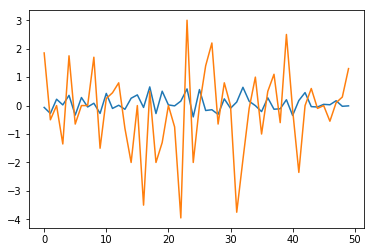

In [141]:
plt.plot(predicted[:50])
plt.plot(yTest[:50])
plt.show()

In [154]:
dataInit['close'][trainBegin:].shape
xTest.shape


(1556, 4, 1)

/home/s2c/anaconda3/envs/AlgoTrading/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


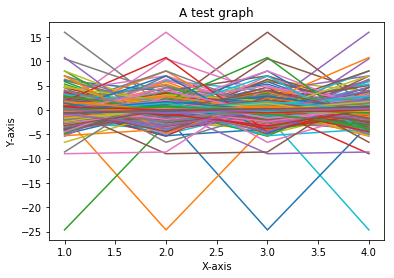

In [57]:
x = range(1,lag+1)
for i in range(0,xTest.shape[0]):
    plt.plot(x,xTest[i])
    
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("A test graph")    
plt.legend()
plt.show()

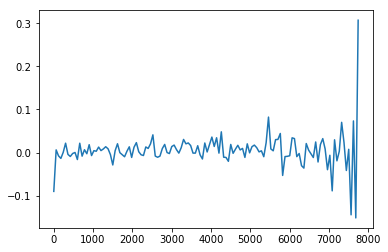

In [71]:

end = len(data)
skip = 60
#data = readData("data/A2Z.csv")
#df = data['close']
#temp = (df - df.mean()) / (df.max() - df.min())
x = range(1,end+1,skip)
plt.plot(x,[data.autocorr(i) for i in range(1,end+1,skip)])
plt.show()


In [160]:
predicted.shape

(1556, 1)

In [168]:
corr = 0
wrong = 0
total = 0
totalPreds = len(yTest)
for i in range(0,totalPreds):
    total+= 1
    if predicted[i] > 0 and yTest[i] > 0:
        corr += 1      
    elif predicted[i] < 0 and yTest[i] < 0:
        corr += 1
    else:
        wrong +=1

In [171]:
corr+wrong

1556